## Connecting libraries ##

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from data_manager import DataManager
from rating_manager import RatingManager
from manifold_manager import ManifoldManager

/Users/vinetiger/Работа💸/Лаборатория СПБПУ/neuronal_activity_estimation_with_manifolds/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions ##

### Functions for rendering ###

In [3]:

def plot_ellipsoid(ax, mean, cov, color, n_std=2):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=color, edgecolor='black', alpha=0.2)
    
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean[0], mean[1])
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

def plot_condition_data(data, ellipsoid_error=False,
                        ellipsoid_cls='run',
                        equal_limits = None,
                        render_manifold=True,
                        render_only_first_projection=False):
    colors = plt.cm.viridis(np.linspace(0, 1, 3))
    classes = ['sit', 'groom', 'run']

    if render_manifold:

        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(111, projection='3d')

        for cls, color in zip(classes, colors):
            subset = data[data['condition'] == cls]
            ax.scatter(subset['C1'], subset['C2'], subset['C3'], color=color, label=f'Class {cls}')

        ax.set_xlabel('С1')
        ax.set_ylabel('С2')
        ax.set_zlabel('С3')
        ax.legend()
        plt.savefig('man.png')
        plt.show()


    if render_only_first_projection:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        axs = [ax]
    else:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for cls, color in zip(classes, colors):
        subset = data[data['condition'] == cls]
        axs[0].scatter(subset['C1'], subset['C2'], color=color, label=f'Class {cls}')
        
        if ellipsoid_error and len(subset) > 1 and cls == ellipsoid_cls:
            cov = np.cov(subset[['C1', 'C2']].T)
            mean = subset[['C1', 'C2']].mean().values
            plot_ellipsoid(axs[0], mean, cov, color)

    axs[0].set_xlabel('C1')
    axs[0].set_ylabel('C2')
    axs[0].legend()

    if render_only_first_projection:
        axs[0].set_xlim(*equal_limits)
        axs[0].set_ylim(*equal_limits)
        return

    for cls, color in zip(classes, colors):
        subset = data[data['condition'] == cls]
        axs[1].scatter(subset['C1'], subset['C3'], color=color, label=f'Class {cls}')
        
        if ellipsoid_error and len(subset) > 1 and cls == ellipsoid_cls:
            cov = np.cov(subset[['C1', 'C3']].T)
            mean = subset[['C1', 'C3']].mean().values
            plot_ellipsoid(axs[1], mean, cov, color)

    axs[1].set_xlabel('C1')
    axs[1].set_ylabel('C3')
    axs[1].legend()

    for cls, color in zip(classes, colors):
        subset = data[data['condition'] == cls]
        axs[2].scatter(subset['C2'], subset['C3'], color=color, label=f'Class {cls}')
        
        if ellipsoid_error and len(subset) > 1 and cls == ellipsoid_cls:
            cov = np.cov(subset[['C2', 'C3']].T)
            mean = subset[['C2', 'C3']].mean().values
            plot_ellipsoid(axs[2], mean, cov, color)

    axs[2].set_xlabel('C2')
    axs[2].set_ylabel('C3')
    axs[2].legend()

    if equal_limits:
        for ax in axs:
            ax.set_xlim(*equal_limits)
            ax.set_ylim(*equal_limits)

    plt.show()


In [4]:
def plot_polar_data(data):

    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(data['C1'], data['C2'], data['C3'], c=data['theta'], cmap='viridis')
    ax.set_xlabel('C1')
    ax.set_ylabel('C2')
    ax.set_zlabel('C3')
    ax.set_title('3D Plot')
    fig.colorbar(sc, ax=ax, label='Parameter')


    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    sc_xy = axs[0].scatter(data['C1'], data['C2'], c=data['theta'], cmap='viridis')
    axs[0].set_xlabel('C1')
    axs[0].set_ylabel('C2')
    axs[0].set_title('C1 C2 Projection')
    fig.colorbar(sc_xy, ax=axs[0], label='Parameter')


    sc_xz = axs[1].scatter(data['C1'], data['C3'], c=data['theta'], cmap='viridis')
    axs[1].set_xlabel('C1')
    axs[1].set_ylabel('C3')
    axs[1].set_title('C1 C3 Projection')
    fig.colorbar(sc_xz, ax=axs[1], label='Parameter')


    sc_yz = axs[2].scatter(data['C2'], data['C3'], c=data['theta'], cmap='viridis')
    axs[2].set_xlabel('C2')
    axs[2].set_ylabel('C3')
    axs[2].set_title('C2 C3 Projection')
    fig.colorbar(sc_yz, ax=axs[2], label='Parameter')

    plt.tight_layout()
    plt.show()

### Functions for calculating ellipse parameters ###

In [5]:
def calculate_square_from_data(data):
    cov_matrix = np.cov(data, rowvar=False)

    eigenvalues, _ = np.linalg.eigh(cov_matrix)

    a = np.sqrt(max(eigenvalues))
    b = np.sqrt(min(eigenvalues))

    return a * b


def calculate_eccentricity_from_data(data):
    cov_matrix = np.cov(data, rowvar=False)
    eigenvalues, _ = np.linalg.eigh(cov_matrix)

    a = np.sqrt(max(eigenvalues))
    b = np.sqrt(min(eigenvalues))

    return (1 - (b ** 2 / a ** 2))**0.5

def calculate_eccentricity_for_manifold(manifold):
    return (
        calculate_eccentricity_from_data(manifold[['C1', 'C2']]),
        calculate_eccentricity_from_data(manifold[['C1', 'C3']]),
        calculate_eccentricity_from_data(manifold[['C2', 'C3']])
    )

def calculate_square_for_manifold(manifold):
    return (
        calculate_square_from_data(manifold[['C1', 'C2']]),
        calculate_square_from_data(manifold[['C1', 'C3']]),
        calculate_square_from_data(manifold[['C2', 'C3']])
    )

### Functions for compressing state data series ###

In [6]:
def get_condition_sample_data(final_length, tracking): 
    missing_frames = 9000 - tracking.shape[0]
    condition = pd.concat([
        pd.Series(['' for i in range(missing_frames // 2)]),
        tracking.loc[:, ['groom', 'run', 'sit', 'stand']].idxmax(axis=1).fillna(''),
        pd.Series(['' for i in range(missing_frames // 2 + 1)])
        ], ignore_index=True)
    condition = pd.Series([condition[i*(9000 // final_length):(i+1)* (9000 // final_length)].mode()[0] for i in range(final_length)])
    return condition.rename('condition')

In [7]:
def get_polar_sample_data(final_length, tracking): 
    missing_frames = 9000 - tracking.shape[0]
    
    r = pd.concat([
        pd.Series([0 for i in range(missing_frames // 2)]),
        pd.Series(np.sqrt(tracking['X, px']**2 + tracking['Y, px']**2)),
        pd.Series([0 for i in range(missing_frames // 2 + 1)])
        ], ignore_index=True)
    
    theta = pd.concat([
        pd.Series([0 for i in range(missing_frames // 2)]),
        pd.Series(np.degrees(np.arctan2(tracking['Y, px'], tracking['X, px']))),
        pd.Series([0 for i in range(missing_frames // 2 + 1)])
        ], ignore_index=True)

    r = pd.Series([r[i*(9000 // final_length):(i+1)* (9000 // final_length)].mean() for i in range(final_length)])
    theta = pd.Series([theta[i*(9000 // final_length):(i+1)* (9000 // final_length)].mean() for i in range(final_length)])
    return pd.concat([r, theta], axis=1).rename(columns={0: 'r', 1: 'theta'})

## Connecting data ##

In [8]:
WT_mice = [3, 5, 7, 106, 102, 109, 110]
transgenic_mice_drug = [12, 13, 111, 115, 113, 114]
transgenic_mice_without_drug = [1, 15, 16, 117, 123, 118]

In [9]:
WT_mice_dict = {3: [1, 2, 3, 4], 5: [1, 3, 4], 7:[1, 2, 3, 4], 102: [1, 2], 106: [1, 2], 109: [1, 2], 110: [2]}
transgenic_mice_drug_dict = {12: [1, 2, 3, 4], 13: [1, 2, 3, 4], 111: [1, 2, 4], 113: [1, 2], 114:[2], 115: [1, 2, 4]}
transgenic_mice_without_drug_dict = {1: [1, 2, 3, 4], 15: [1, 2, 3, 4], 16: [1, 2, 4], 117: [1, 2, 4], 118: [1, 2], 123: [1, 2]}

mice = {}
mice.update(WT_mice_dict)
mice.update(transgenic_mice_drug_dict)
mice.update(transgenic_mice_without_drug_dict)

In [10]:
data_manager = DataManager()
for mouse, sessions in mice.items():
    for session in sessions:
        data_manager.load_data(f'data/alzheimer data/mouse {mouse}/session {session}/minian/C.zarr', mouse)
    time_sample_size = 30

In [11]:
data_map = data_manager.get_time_split_data(time_sample_size, average_samples=False)

In [13]:
mice_tracking = {}
for mouse, sessions in mice.items():
    for session in sessions:
        if mouse not in mice_tracking:
            mice_tracking[mouse] = [pd.read_excel(f'data/mouse tracking/mouse{mouse}/session_{session}.xlsx')]
        else:
            mice_tracking[mouse].append(pd.read_excel(f'data/mouse tracking/mouse{mouse}/session_{session}.xlsx'))

## Building manifolds and connecting to mouse behavior ##

### Build once ###

In [14]:
manifold_manager = ManifoldManager()
manifold_map = {}
for tag, sessions in data_map.items():
    for session in sessions:
        if tag not in manifold_map:
            manifold_map[tag] = [manifold_manager.t_SNE(session)]
        else:
            manifold_map[tag].append(manifold_manager.t_SNE(session))

In [15]:
data = {}
for mouse, sessions in mice_tracking.items():
    for i, session in enumerate(sessions):
        mouse_tracking = pd.concat([pd.DataFrame(manifold_map[mouse][i], columns=['C1', 'C2', 'C3']),
            get_condition_sample_data(manifold_map[mouse][i].shape[0], mice_tracking[mouse][i]),
            get_polar_sample_data(manifold_map[mouse][i].shape[0], mice_tracking[mouse][i])
            ], axis=1)
        if mouse not in data:
            data[mouse] = [mouse_tracking]
        else:
            data[mouse].append(mouse_tracking)
            

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/1810418871.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  tracking.loc[:, ['groom', 'run', 'sit', 'stand']].idxmax(axis=1).fillna(''),
/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/1810418871.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  tracking.loc[:, ['groom', 'run', 'sit', 'stand']].idxmax(axis=1).fillna(''),
/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/1773129889.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  r = pd.concat(

### Building manifolds several times, followed by averaging ###

In [16]:
from tqdm import tqdm

rating_manager = RatingManager()

square_data = {}
eccentricities_data = {}
intraclaster_data = {}

for i in tqdm(range(1), desc='Processing'):
    data_manager = DataManager()
    for mouse, sessions in mice.items():
        for session in sessions:
            data_manager.load_data(f'data/alzheimer data/mouse {mouse}/session {session}/minian/C.zarr', mouse)

    data_map = data_manager.get_time_split_data(time_sample_size, average_samples=False)
    
    time_sample_size = 30
    manifold_manager = ManifoldManager()
    manifold_map = {}
    for tag, sessions in data_map.items():
        for session in sessions:
            if tag not in manifold_map:
                manifold_map[tag] = [manifold_manager.t_SNE(session)]

            else:
                manifold_map[tag].append(manifold_manager.t_SNE(session))


    data = {}
    for mouse, sessions in mice_tracking.items():
        for i, session in enumerate(sessions):
            mouse_tracking = pd.concat([pd.DataFrame(manifold_map[mouse][i], columns=['C1', 'C2', 'C3']),
                get_condition_sample_data(manifold_map[mouse][i].shape[0], mice_tracking[mouse][i]),
                get_polar_sample_data(manifold_map[mouse][i].shape[0], mice_tracking[mouse][i])
                ], axis=1)
            if mouse not in data:
                data[mouse] = [mouse_tracking]
            else:
                data[mouse].append(mouse_tracking)

    for mouse, sessions in mice.items():
        for i, session in enumerate(sessions):
            condition = 'sit'

            if data[mouse][i][data[mouse][i]['condition'] == condition].empty or \
            data[mouse][i][data[mouse][i]['condition'] == condition].shape[0] <= 1:
                eccentricities = (0, 0, 0)
                squares = (0, 0, 0)
            else:
                eccentricities = calculate_eccentricity_for_manifold(data[mouse][i][data[mouse][i]['condition'] == condition])
                squares = calculate_square_for_manifold(data[mouse][i][data[mouse][i]['condition'] == condition])

            intraclaster = rating_manager.intracluster_distance(data[mouse][i][['C1', 'C2', 'C3']])

            
            if mouse not in square_data:
                square_data[mouse] = {session : [squares]}
            elif session not in square_data[mouse]:
                square_data[mouse][session] = [squares]
            else:
                square_data[mouse][session].append(squares)

            if mouse not in eccentricities_data:
                eccentricities_data[mouse] = {session : [eccentricities]}
            elif session not in eccentricities_data[mouse]:
                eccentricities_data[mouse][session] = [eccentricities]
            else:
                eccentricities_data[mouse][session].append(eccentricities)

            if mouse not in intraclaster_data:
                intraclaster_data[mouse] = {session : [intraclaster]}
            elif session not in intraclaster_data[mouse]:
                intraclaster_data[mouse][session] = [intraclaster]
            else:
                intraclaster_data[mouse][session].append(intraclaster)

Processing:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/1810418871.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  tracking.loc[:, ['groom', 'run', 'sit', 'stand']].idxmax(axis=1).fillna(''),
/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/1810418871.py:5: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  tracking.loc[:, ['groom', 'run', 'sit', 'stand']].idxmax(axis=1).fillna(''),
/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/1773129889.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entr

 ### Getting a dataframe with values of eccentricities and areas for all mice for all iterations ###

In [17]:
def get_param_df(param_data):
    param_df = []
    for mouse_type, mice_num in [('wild', WT_mice), ('transgenic', transgenic_mice_without_drug), 
                                ('treated', transgenic_mice_drug)]:
        for mouse_num in mice_num:
            for session, param_session in param_data[mouse_num].items():
                param_df.append(list(np.array(param_session).mean(axis=1)) + [mouse_type, mouse_num, session])

    return pd.DataFrame(param_df).rename({10: 'type', 11: 'mouse_num', 12: 'session_num'}, axis=1)

In [18]:
square_df = get_param_df(square_data)

In [19]:
square_df.shape

(53, 4)

In [20]:
square_df.to_excel(f'square_{condition}_exp_10.xlsx')

In [21]:
eccentricities_df = get_param_df(eccentricities_data)

In [22]:
eccentricities_df.to_excel(f'eccentricities_{condition}_exp_10.xlsx')

## Building a dataframe with session attributes without averaging over iterations ##

In [23]:
feature_list_data = []
for mouse, sessions in mice.items():
    for session in sessions:
        feature_list_data.append([mouse, session] +
                                 intraclaster_data[mouse][session] +
                                 list(np.mean(np.array(square_data[mouse][session]), axis=1)) +
                                 list(np.mean(np.array(eccentricities_data[mouse][session]), axis=1))
                                )
                

In [24]:
columns_name_dict = {0: 'mouse', 1: 'session'}
columns_name_dict.update({i: f'intraclaster_distance_{i - 2}' for i in range(2, 12)})
columns_name_dict.update({i: f'square_{i - 12}' for i in range(12, 22)})
columns_name_dict.update({i: f'eccentricity_{i - 22}' for i in range(22, 32)})

feature_data = pd.DataFrame(feature_list_data).rename(columns_name_dict, axis=1)

In [25]:
def determine_mouse_type(mouse):
    if mouse in transgenic_mice_without_drug:
        return 'transgenic_without_drug'
    elif mouse in transgenic_mice_drug:
        return 'transgenic_with_drug'
    elif mouse in WT_mice:
        return 'wild'

In [26]:
feature_data['type'] = feature_data['mouse'].apply(determine_mouse_type)

## Building a dataframe with session attributes by averaging all the results ##

In [27]:
feature_list_data = []
for mouse, sessions in mice.items():
    for session in sessions:
        feature_list_data.append([mouse, session] +
                                 list(np.mean(np.array(square_data[mouse][session]), axis=0)) +
                                 list(np.mean(np.array(eccentricities_data[mouse][session]), axis=0)) +
                                 [np.mean(np.array(intraclaster_data[mouse][session]))]
                                )
                

In [28]:
feature_data = pd.DataFrame(feature_list_data, columns=['mouse', 'session',
                                                        'square_1', 'square_2',
                                                        'square_3', 'eccentricities_1',
                                                        'eccentricities_2', 'eccentricities_3',
                                                        'intraclaster_distance'])

In [29]:
def determine_mouse_type(mouse):
    if mouse in transgenic_mice_without_drug:
        return 'transgenic_without_drug'
    elif mouse in transgenic_mice_drug:
        return 'transgenic_with_drug'
    elif mouse in WT_mice:
        return 'wild'

In [30]:
feature_data['type'] = feature_data['mouse'].apply(determine_mouse_type)

In [31]:
feature_data['eccentricities_mean'] = feature_data[['eccentricities_1', 'eccentricities_2', 'eccentricities_3']].mean(axis=1)
feature_data['square_mean'] = feature_data[['square_1','square_2','square_3']].mean(axis=1)


## Classification ##

In [32]:
feature_data_without_drug = feature_data[feature_data['type'] != 'transgenic_with_drug']
feature_data_without_drug['type'] = feature_data_without_drug['type'].apply(lambda x: 0 if x == 'wild' else 1)

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/3663594633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data_without_drug['type'] = feature_data_without_drug['type'].apply(lambda x: 0 if x == 'wild' else 1)


In [33]:
feature_data_without_transgenic = feature_data[feature_data['type'] != 'transgenic_without_drug']
feature_data_without_transgenic['type'] = feature_data_without_transgenic['type'].apply(lambda x: 0 if x == 'wild' else 1)

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/461811998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data_without_transgenic['type'] = feature_data_without_transgenic['type'].apply(lambda x: 0 if x == 'wild' else 1)


In [34]:
feature_data_without_wild = feature_data[feature_data['type'] != 'wild']
feature_data_without_wild['type'] = feature_data_without_wild['type'].apply(lambda x: 1 if x == 'transgenic_without_drug' else 0)

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/2804006024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data_without_wild['type'] = feature_data_without_wild['type'].apply(lambda x: 1 if x == 'transgenic_without_drug' else 0)


In [35]:
def train_classifier(feature_type_data, iteration=100):
    result_df = []
    for exp_num in range(1):
        accuracy_score_list = []
        precision_score_list = []
        recall_score_list = []
        f1_score_list = []


        for i in range(iteration):
            X_train, X_test, y_train, y_test = train_test_split(feature_type_data[['intraclaster_distance']],
                                                        feature_type_data['type'],
                                                        test_size=0.3,
                                                        stratify=feature_type_data['type'])
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            model = LogisticRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accuracy_score_list.append(accuracy_score(y_test, y_pred))
            precision_score_list.append(precision_score(y_test, y_pred))
            recall_score_list.append(recall_score(y_test, y_pred))
            f1_score_list.append(f1_score(y_test, y_pred))
        
        result_df.append([exp_num + 1] + [np.mean(accuracy_score_list),
                                                        np.mean(precision_score_list),
                                                        np.mean(recall_score_list),
                                                        np.mean(f1_score_list)
                                                        ])
    return pd.DataFrame(result_df).rename({0: 'exp_num', 1: 'accuracy', 2: 'precision',
                                                3: 'recall', 4: 'f1'}, axis=1)

**Разделение на трансгеных и пролеченных мышей:**

In [36]:
feature_data_without_wild.dropna(inplace=True)

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/1057655668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data_without_wild.dropna(inplace=True)


In [37]:
trans_vs_treated_df = train_classifier(feature_data_without_wild)

In [38]:
trans_vs_treated_df.mean()

exp_num      1.000000
accuracy     0.660909
precision    0.705587
recall       0.698333
f1           0.681897
dtype: float64

**Разделение на трансгеных и диких мышей:**

In [39]:
feature_data_without_drug.dropna(inplace=True)

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/3227292492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data_without_drug.dropna(inplace=True)


In [40]:
trans_vs_wild_df = train_classifier(feature_data_without_drug)

In [41]:
trans_vs_wild_df.mean()

exp_num      1.000000
accuracy     0.675455
precision    0.685520
recall       0.751333
f1           0.690911
dtype: float64

**Разделение на диких и пролеченных мышей:**

In [42]:
feature_data_without_transgenic.dropna(inplace=True)

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/2754587212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data_without_transgenic.dropna(inplace=True)


In [43]:
wild_vs_treated_df = train_classifier(feature_data_without_transgenic)

In [44]:
wild_vs_treated_df.mean()

exp_num      1.000000
accuracy     0.398182
precision    0.354913
recall       0.436000
f1           0.385238
dtype: float64

## Building boxplots ##

### Building boxplots by session ###

In [45]:
healthy_boxplot_data = []
transgenic_boxplot_data = []
drug_boxplot_data = []
for mouse, sessions in square_data.items():
    for session_num, session in sessions.items():
        if mouse in transgenic_mice_without_drug:
            transgenic_boxplot_data.append(np.mean((np.mean(session, axis=0))))

for mouse, sessions in square_data.items():
    for session_num, session in sessions.items():
        if mouse in [12, 13, 111, 115]:
            drug_boxplot_data.append(np.mean((np.mean(session, axis=0))))

for mouse, sessions in square_data.items():
    for session_num, session in sessions.items():
        if mouse in WT_mice:
            healthy_boxplot_data.append(np.mean((np.mean(session, axis=0))))
        

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/2786763382.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([healthy_boxplot_data, transgenic_boxplot_data, drug_boxplot_data],


{'whiskers': [<matplotlib.lines.Line2D at 0x3139c8ee0>,
 'caps': [<matplotlib.lines.Line2D at 0x3130194f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x3139c8460>,
 'medians': [<matplotlib.lines.Line2D at 0x313019490>,
 'fliers': [<matplotlib.lines.Line2D at 0x3130195e0>,
 'means': []}

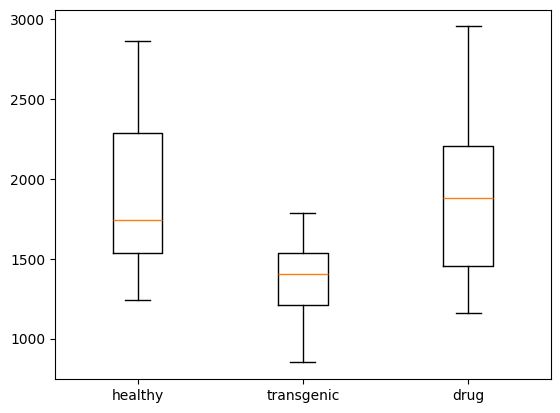

In [46]:
plt.boxplot([healthy_boxplot_data, transgenic_boxplot_data, drug_boxplot_data],
            labels=['healthy', 'transgenic', 'drug'])

In [47]:
healthy_boxplot_data = []
transgenic_boxplot_data = []
drug_boxplot_data = []
for mouse, sessions in eccentricities_data.items():
    for session_num, session in sessions.items():
        if mouse in transgenic_mice_without_drug:
            transgenic_boxplot_data.append(np.mean((np.mean(session, axis=0))))

for mouse, sessions in eccentricities_data.items():
    for session_num, session in sessions.items():
        if mouse in [12, 13, 111, 115]:
            drug_boxplot_data.append(np.mean((np.mean(session, axis=0))))

for mouse, sessions in eccentricities_data.items():
    for session_num, session in sessions.items():
        if mouse in WT_mice:
            healthy_boxplot_data.append(np.mean((np.mean(session, axis=0))))
        

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/2786763382.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([healthy_boxplot_data, transgenic_boxplot_data, drug_boxplot_data],


{'whiskers': [<matplotlib.lines.Line2D at 0x312aa9280>,
 'caps': [<matplotlib.lines.Line2D at 0x3128c82b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x312824d00>,
 'medians': [<matplotlib.lines.Line2D at 0x312af2ca0>,
 'fliers': [<matplotlib.lines.Line2D at 0x312af2a00>,
 'means': []}

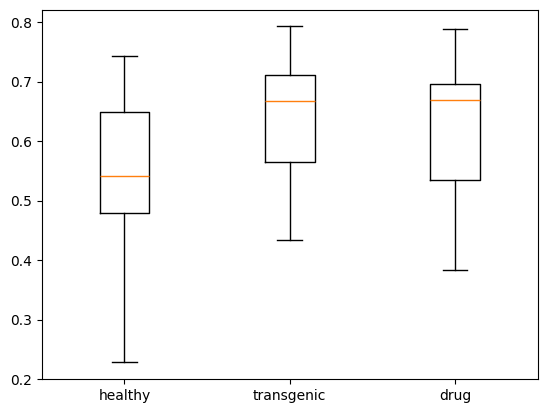

In [48]:
plt.boxplot([healthy_boxplot_data, transgenic_boxplot_data, drug_boxplot_data],
            labels=['healthy', 'transgenic', 'drug'])

### Building boxplots based on mice ###

In [49]:
healthy_boxplot_data = []
transgenic_boxplot_data = []
drug_boxplot_data = []

for mouse, sessions in square_data.items():
    mouse_boxplot_values = []
    if mouse in transgenic_mice_without_drug:
        for session_num, session in sessions.items():
            mouse_boxplot_values.append(np.mean((np.mean(session, axis=0))))
        transgenic_boxplot_data.append(np.mean(mouse_boxplot_values))


for mouse, sessions in square_data.items():
    mouse_boxplot_values = []
    if mouse in transgenic_mice_drug:
        for session_num, session in sessions.items():
            mouse_boxplot_values.append(np.mean((np.mean(session, axis=0))))
        drug_boxplot_data.append(np.mean(mouse_boxplot_values))

for mouse, sessions in square_data.items():
    mouse_boxplot_values = []
    if mouse in WT_mice:
        for session_num, session in sessions.items():
            mouse_boxplot_values.append(np.mean((np.mean(session, axis=0))))
        healthy_boxplot_data.append(np.mean(mouse_boxplot_values))
        

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/2786763382.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([healthy_boxplot_data, transgenic_boxplot_data, drug_boxplot_data],


{'whiskers': [<matplotlib.lines.Line2D at 0x3127e4970>,
 'caps': [<matplotlib.lines.Line2D at 0x3127e4d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x312ec8280>,
 'medians': [<matplotlib.lines.Line2D at 0x312c03b80>,
 'fliers': [<matplotlib.lines.Line2D at 0x312c31220>,
 'means': []}

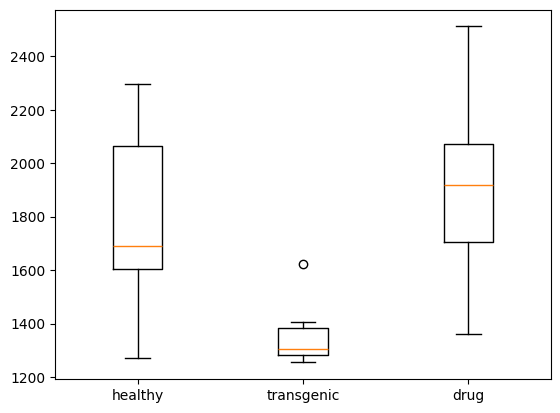

In [50]:
plt.boxplot([healthy_boxplot_data, transgenic_boxplot_data, drug_boxplot_data],
            labels=['healthy', 'transgenic', 'drug'])

In [51]:
healthy_boxplot_data = []
transgenic_boxplot_data = []
drug_boxplot_data = []

for mouse, sessions in eccentricities_data.items():
    mouse_boxplot_values = []
    if mouse in transgenic_mice_without_drug:
        for session_num, session in sessions.items():
            mouse_boxplot_values.append(np.mean((np.mean(session, axis=0))))
        transgenic_boxplot_data.append(np.mean(mouse_boxplot_values))


for mouse, sessions in eccentricities_data.items():
    mouse_boxplot_values = []
    if mouse in transgenic_mice_drug:
        for session_num, session in sessions.items():
            mouse_boxplot_values.append(np.mean((np.mean(session, axis=0))))
        drug_boxplot_data.append(np.mean(mouse_boxplot_values))

for mouse, sessions in eccentricities_data.items():
    mouse_boxplot_values = []
    if mouse in WT_mice:
        for session_num, session in sessions.items():
            mouse_boxplot_values.append(np.mean((np.mean(session, axis=0))))
        healthy_boxplot_data.append(np.mean(mouse_boxplot_values))
        

/var/folders/lm/77277v3s6_9cj90fkcqbndg00000gn/T/ipykernel_68737/2786763382.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([healthy_boxplot_data, transgenic_boxplot_data, drug_boxplot_data],


{'whiskers': [<matplotlib.lines.Line2D at 0x312c02a30>,
 'caps': [<matplotlib.lines.Line2D at 0x312c02550>,
 'boxes': [<matplotlib.lines.Line2D at 0x312c02ac0>,
 'medians': [<matplotlib.lines.Line2D at 0x312af9d90>,
 'fliers': [<matplotlib.lines.Line2D at 0x312af9ee0>,
 'means': []}

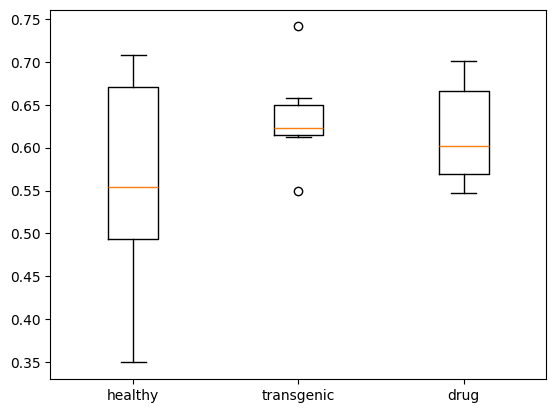

In [52]:
plt.boxplot([healthy_boxplot_data, transgenic_boxplot_data, drug_boxplot_data],
            labels=['healthy', 'transgenic', 'drug'])

## Plotting graphs with error ellipses ##

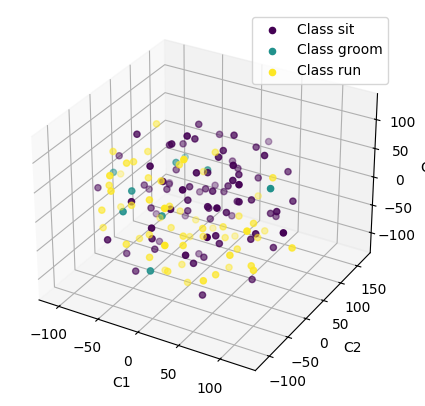

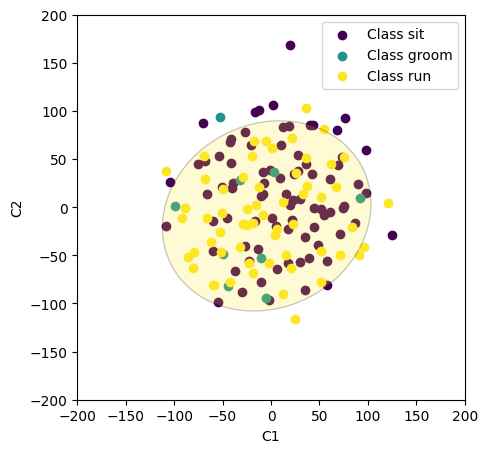

In [53]:
plot_condition_data(pd.concat([data[3][0][['C1', 'C2', 'C3', 'condition']]]),
                    ellipsoid_error=True,
                    equal_limits=[-200, 200],
                    ellipsoid_cls='run',
                    render_manifold=True,
                    render_only_first_projection=True)

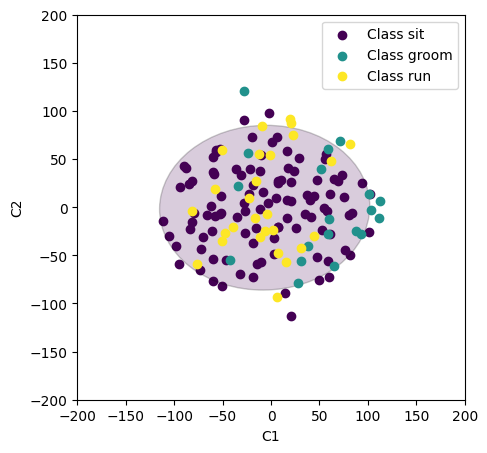

In [54]:
plot_condition_data(data[12][1],
                    ellipsoid_error=True,
                    equal_limits=[-200, 200],
                    ellipsoid_cls='sit',
                    render_manifold=False,
                    render_only_first_projection=True)

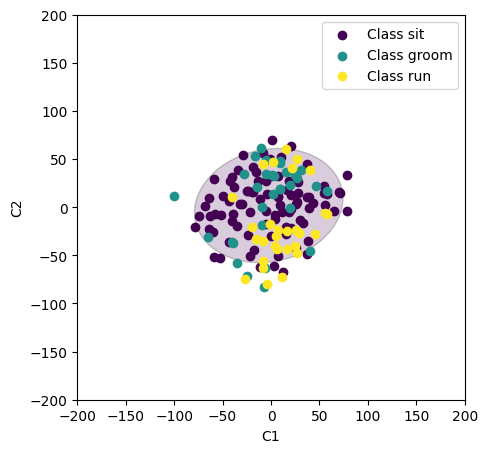

In [55]:
plot_condition_data(data[1][1],
                    ellipsoid_error=True,
                    equal_limits=[-200, 200],
                    ellipsoid_cls='sit',
                    render_manifold=False,
                    render_only_first_projection=True)